# Model Development

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import tqdm
import re
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from ml_utils.preprocessing import target_melt
from ml_utils.tools import format_timedelta
import datetime

In [132]:
# from ml_utils.preprocessing import CategoricalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from category_encoders import MEstimateEncoder, JamesSteinEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, \
                            roc_curve, \
                            auc, \
                            classification_report, \
                            confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            log_loss

from sklearn.preprocessing import LabelEncoder

In [3]:
import shap
shap.initjs()

In [4]:
vcdb = pd.read_excel('data/vcdb_decoded.xlsx')

In [5]:
pd.__version__

'1.0.1'

In [6]:
with open('data/vcdb-enum.json') as f:
    enums = json.load(f)
    
with open('data/vcdb-merged.json') as f:
    schema = json.load(f)

In [7]:
keynames = []
with open('data/vcdb-keynames-real.txt') as f:
    for line in f:
        keynames.append(line.replace('\n', ''))
        

# Creating a configuration file / data dictionary

In [8]:
config = {
    'base_data': {},
    'targets': {}
}

# One-hot encoded features

In [9]:
ohe_cols = [col for col in vcdb if vcdb[col].isin([True, False]).all()]
print('%s hot encoded features'%len(ohe_cols))
      
assert vcdb[ohe_cols].notnull().all().all()
assert len(ohe_cols) == len(vcdb.select_dtypes('bool').columns)

476 hot encoded features


In [10]:
config['base_data']['one-hot encoded'] = ohe_cols

# Null Columns

In [11]:
null_cols = vcdb.columns[vcdb.isnull().all()]
null_cols = [col for col in null_cols if col not in ohe_cols]
print('%s completely null features'%len(null_cols))
config['base_data']['all null'] = null_cols

91 completely null features


Some of these are fine because they are one_hot encoded columns

In [12]:
some_nulls = [col for col in vcdb.columns[vcdb.isnull().any()] if col not in null_cols]
print('%s features with some nulls'%len(some_nulls))
config['base_data']['some null'] = some_nulls

115 features with some nulls


## Null categorical features with an Unknown category
We replace columns with "Unknown" as a value with pandas nulls, this way we can figure out a good imputation strategy for these rather than treat "unknown" as a category, since it is not useful to us.

In [13]:
ukn_cols = [col for col in some_nulls if (vcdb[col].astype(str).str.lower()=='unknown').any()]
for col in ukn_cols:
    vcdb.loc[vcdb[col].astype(str).str.lower()=='unknown', col] = None

assert not vcdb[ukn_cols].apply(lambda col: (col.astype(str).str.lower()=='unknown').any()).any()
config['base_data']['explicitly unknown'] = ukn_cols

# Data Types

### Floats

In [14]:
vcdb.select_dtypes('float64').notnull().sum().sort_values(ascending=False)

attribute.confidentiality.data_total                 4394
attribute.confidentiality.data.amount.Medical        1711
attribute.confidentiality.data.amount.Personal       1192
victim.locations_affected                            1185
victim.revenue.amount                                 505
                                                     ... 
asset.assets.amount.U - Telephone                       0
asset.assets.amount.U - Unknown                         0
asset.assets.amount.U - VoIP phone                      0
attribute.confidentiality.data.amount.Source code       0
asset.assets.amount.E - Other                           0
Length: 149, dtype: int64

In [15]:
vcdb.dtypes.value_counts()

bool       476
float64    149
object      66
int64        1
dtype: int64

In [16]:
float_cols = [col for col in vcdb.select_dtypes('float64') if not vcdb[col].isnull().all()]
len(float_cols)
config['base_data']['floats'] = float_cols

## Free Text

In [17]:
text_cols = [col for col in vcdb if 'notes' in col.lower() or 'summary' in col.lower()]
text_cols += ['reference']
text_cols

['action.environmental.notes',
 'action.error.notes',
 'action.hacking.notes',
 'action.malware.notes',
 'action.misuse.notes',
 'action.physical.notes',
 'action.social.notes',
 'action.unknown.notes',
 'asset.notes',
 'attribute.availability.notes',
 'attribute.confidentiality.notes',
 'attribute.integrity.notes',
 'discovery_notes',
 'impact.notes',
 'notes',
 'plus.analyst_notes',
 'plus.event_chain.summary',
 'plus.pci.notes',
 'summary',
 'victim.notes',
 'victim.secondary.notes',
 'reference']

In [18]:
vcdb[text_cols].notnull().sum()

action.environmental.notes            1
action.error.notes                  299
action.hacking.notes                192
action.malware.notes                102
action.misuse.notes                 118
action.physical.notes                30
action.social.notes                  60
action.unknown.notes                  5
asset.notes                         173
attribute.availability.notes        114
attribute.confidentiality.notes     727
attribute.integrity.notes           234
discovery_notes                     415
impact.notes                        133
notes                               423
plus.analyst_notes                  167
plus.event_chain.summary              0
plus.pci.notes                        0
summary                            7329
victim.notes                         62
victim.secondary.notes               74
reference                          7379
dtype: int64

## Text cleaning

In [19]:
cat_and_text_cols = vcdb.select_dtypes('O').columns
for col in cat_and_text_cols:
    vcdb[col] = (
        vcdb[col]
            .fillna('placeholder_nan')
            .astype(str)
            .str.lower()
            .replace('placeholder_nan', np.nan)
    )

## Categoricals

In [20]:
{col: vcdb[col].unique() for col in vcdb if 'cve' in col}

{'action.hacking.cve': array([nan, 'cve-2008-4250', 'heartbleed', 'cve-2012-0507',
        'unknown vuln', 'cve-2016-6483', 'cve unknown', 'cve-2012-5385',
        'cve-2014-0160', 'cve-2017-5638', 'cve-2012-4969', 'cve-2013-0632',
        'cve-2013-1347,cve-2013-2423,cve-2013-1493', 'cve-2017-0144',
        'wordpress'], dtype=object),
 'action.malware.cve': array([nan, 'cve-2010-0249',
        'cve-2009-3129, cve-2010-3333, cve-2012-0158, cve-2011-3544',
        'cve-2013-0640,cve-2013-0641', 'cve-2012-4681;cve-2013-2423',
        'cve-2013-3893', 'cve 2012-4792',
        'cve-2013-1347, cve-2013-2423, cve-2013-1493', 'cve-2012-4681'],
       dtype=object)}

In [21]:
feature_counts = {}
for col in vcdb.select_dtypes('O'):
    if 'notes' not in col.lower() and col not in ohe_cols:
        feature_counts[col]= vcdb[col].nunique()
feature_counts

{'action.hacking.cve': 14,
 'action.malware.cve': 8,
 'action.malware.name': 21,
 'campaign_id': 10,
 'control_failure': 1,
 'incident_id': 7829,
 'plus.analyst': 69,
 'plus.asset.total': 3,
 'plus.attribute.confidentiality.credit_monitoring': 5,
 'plus.attribute.confidentiality.data_abuse': 3,
 'plus.attribute.confidentiality.data_misuse': 4,
 'plus.attribute.confidentiality.partner_data': 2,
 'plus.f500': 6,
 'plus.github': 4344,
 'plus.master_id': 7832,
 'plus.sub_source': 4,
 'reference': 5925,
 'schema_version': 2,
 'source_id': 1,
 'summary': 6936,
 'victim.industry': 670,
 'victim.region': 38,
 'victim.secondary.victim_id': 234,
 'victim.state': 97,
 'victim.victim_id': 5616,
 'victim.industry3': 115,
 'victim.industry.name': 21,
 'pattern': 10,
 'security_incident': 3,
 'impact.overall_rating': 4,
 'impact.iso_currency_code': 10,
 'confidence': 4,
 'victim.employee_count': 11,
 'victim.country': 134,
 'victim.revenue.iso_currency_code': 2,
 'victim.orgsize': 2,
 'attribute.avai

In [22]:
vcdb[feature_counts.keys()]

,action.hacking.cve,action.malware.cve,action.malware.name,campaign_id,control_failure,incident_id,plus.analyst,plus.asset.total,plus.attribute.confidentiality.credit_monitoring,plus.attribute.confidentiality.data_abuse,...,targeted,cost_corrective_action,asset.cloud,asset.accessibility,asset.country,plus.analysis_status,plus.attack_difficulty_initial,plus.attack_difficulty_legacy,plus.attack_difficulty_subsequent,plus.unknown_unknowns
0,NaN,NaN,NaN,NaN,NaN,0001aa7f-c601-424a-b2b8-be6c9f5164e7,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0008dadb-e83d-4278-a19a-cee01610cf43,swidup,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,000d403e-2dc9-4ea7-9294-bd3938d1c3c7,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0012cc25-9167-40d8-8fe3-3d0dfd8fb6bb,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,00163384-b4d7-46d5-9e6f-543dfb00f598,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,NaN,NaN,NaN,NaN,NaN,b533254c-4713-4fe7-a9f8-412abb4ec664,robert-topper,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,finalized,NaN,NaN,NaN,NaN
7829,NaN,NaN,NaN,NaN,NaN,ffd31fe4-976b-48ca-a111-ef84ebab9b0f,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7830,NaN,NaN,NaN,NaN,NaN,ffda2281-8053-4315-b613-330eb09a4bee,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7831,NaN,NaN,NaN,NaN,NaN,ffdc6655-e421-4bec-835f-1bdfec4f6c70,swidup,no,u,u,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN


In [23]:
def id_generator(dict_var, key):
    """
    Based.
    https://stackoverflow.com/questions/21028979/recursive-iteration-through-nested-json-for-specific-key-in-python
    """
    for k, v in dict_var.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for id_val in id_generator(v, key):
                yield id_val

In [24]:
enums = set()
for enum in id_generator(schema,'enum'):
    enums.add(tuple(enum))

len(enums)

66

In [25]:
pd.Categorical(vcdb['security_incident']).categories

Index(['confirmed', 'near miss', 'suspected'], dtype='object')

# Target Variable Analysis

We start by having at some Incident Description Enumerations to see what is feasible.

#### SECURITY_INCIDENT
- Confirmed: Yes - Confirmed
- Suspected: Suspected
- False positive: False positive (response triggered, but no incident)
- Near miss: Near miss (actions did not compromise asset)

In [26]:
config['targets']['All'] = []

In [27]:
schema['properties']['security_incident']

{'type': 'string',
 'description': 'Confirmed incident?',
 'enum': ['Confirmed', 'Suspected', 'Near miss', 'False positive']}

In [28]:
vcdb['security_incident'].value_counts(dropna=False)

confirmed    7759
suspected      67
near miss       6
NaN             1
Name: security_incident, dtype: int64

In [29]:
config['targets']['All'].append('security_incident')

In [30]:
impact_cols = [col for col in vcdb if col.startswith('impact')]

In [31]:
vcdb[[col for col in vcdb if col.startswith('impact')]].notnull().sum()

impact.loss.amount             0
impact.notes                 133
impact.overall_amount         80
impact.overall_max_amount      1
impact.overall_min_amount      2
impact.overall_rating         27
impact.iso_currency_code     197
dtype: int64

In [32]:
vcdb['impact.overall_rating'].value_counts(dropna=False)

NaN              7806
distracting        13
damaging            8
painful             5
insignificant       1
Name: impact.overall_rating, dtype: int64

In [33]:
config['targets']['All'] += [col for col in vcdb if col.startswith('impact')]

# Predicting C-I-A outcomes

In [34]:
cia_cols = [col for col in vcdb if col.startswith('attribute.')]
config['targets']['All CIA'] = cia_cols

Data Disclosure looks promising as a decision outcome: while there is a class imbalance it is not as extreme as that of security_incidents

In [35]:
vcdb['attribute.confidentiality.data_disclosure'].value_counts()

yes            5076
potentially    1884
no               76
Name: attribute.confidentiality.data_disclosure, dtype: int64

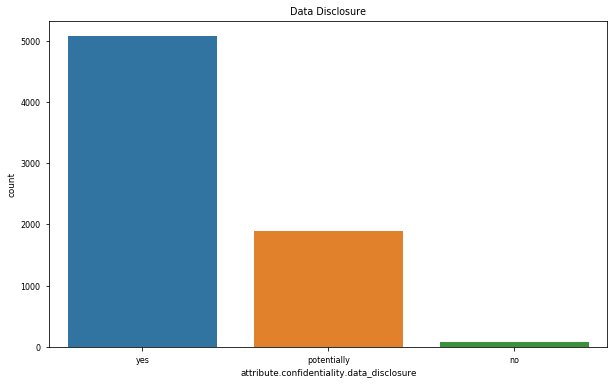

In [36]:
plt.figure(figsize=(10,6))
plt.title('Data Disclosure')
ax = sns.countplot(vcdb['attribute.confidentiality.data_disclosure'])
plt.savefig('figs/data_disclosure_classes.png')

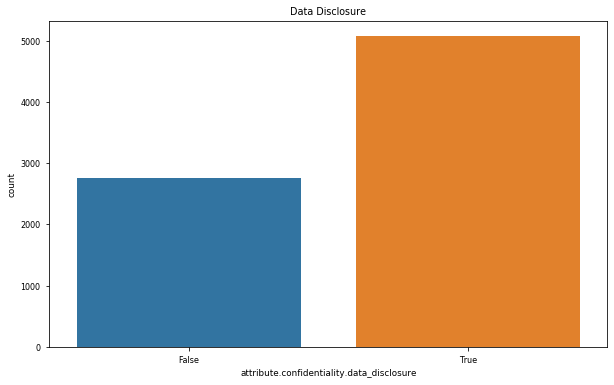

In [37]:
plt.figure(figsize=(10,6))
plt.title('Data Disclosure')
ax = sns.countplot(vcdb['attribute.confidentiality.data_disclosure']=='yes')
plt.savefig('figs/data_disclosure_bool.png')

In [38]:
config['targets']['data_disclosure'] = 'attribute.confidentiality.data_disclosure'

Availability Duration does not seem promising as a decision outcome

In [39]:
config['targets']['All'] += [col for col in vcdb if col.startswith('attribute')]

In [40]:
vcdb['attribute.Confidentiality'].value_counts()

True     7249
False     584
Name: attribute.Confidentiality, dtype: int64

In [41]:
[col for col in vcdb if col.startswith('attribute.confidentiality') and 'variety' in col]

['attribute.confidentiality.data.variety.Bank',
 'attribute.confidentiality.data.variety.Classified',
 'attribute.confidentiality.data.variety.Copyrighted',
 'attribute.confidentiality.data.variety.Credentials',
 'attribute.confidentiality.data.variety.Digital certificate',
 'attribute.confidentiality.data.variety.Internal',
 'attribute.confidentiality.data.variety.Medical',
 'attribute.confidentiality.data.variety.Other',
 'attribute.confidentiality.data.variety.Payment',
 'attribute.confidentiality.data.variety.Personal',
 'attribute.confidentiality.data.variety.Secrets',
 'attribute.confidentiality.data.variety.Source code',
 'attribute.confidentiality.data.variety.System',
 'attribute.confidentiality.data.variety.Unknown',
 'attribute.confidentiality.data.variety.Virtual currency']

In [42]:
vcdb['attribute.Integrity'].value_counts()

False    5998
True     1835
Name: attribute.Integrity, dtype: int64

In [43]:
[col for col in vcdb if col.startswith('attribute.integrity')]

['attribute.integrity.notes',
 'attribute.integrity.variety.Alter behavior',
 'attribute.integrity.variety.Created account',
 'attribute.integrity.variety.Defacement',
 'attribute.integrity.variety.Fraudulent transaction',
 'attribute.integrity.variety.Hardware tampering',
 'attribute.integrity.variety.Log tampering',
 'attribute.integrity.variety.Misrepresentation',
 'attribute.integrity.variety.Modify configuration',
 'attribute.integrity.variety.Modify data',
 'attribute.integrity.variety.Modify privileges',
 'attribute.integrity.variety.Other',
 'attribute.integrity.variety.Repurpose',
 'attribute.integrity.variety.Software installation',
 'attribute.integrity.variety.Unknown']

In [44]:
vcdb['attribute.Availability'].value_counts()

False    5486
True     2347
Name: attribute.Availability, dtype: int64

In [45]:
[col for col in vcdb if col.startswith('attribute.availability')]

['attribute.availability.duration.value',
 'attribute.availability.notes',
 'attribute.availability.variety.Acceleration',
 'attribute.availability.variety.Degradation',
 'attribute.availability.variety.Destruction',
 'attribute.availability.variety.Interruption',
 'attribute.availability.variety.Loss',
 'attribute.availability.variety.Obscuration',
 'attribute.availability.variety.Other',
 'attribute.availability.variety.Unknown',
 'attribute.availability.duration.unit']

In [46]:
vcdb['attribute.availability.duration.value'].notnull().sum()

106

In [47]:
vcdb['control_failure'].value_counts(dropna=False)

NaN                             7832
single factor authentication       1
Name: control_failure, dtype: int64

## Predicting Pattern Outcomes

In [48]:
vcdb['pattern'].value_counts()

miscellaneous errors      1812
privilege misuse          1597
lost and stolen assets    1460
everything else           1026
web applications           896
payment card skimmers      278
crimeware                  267
cyber-espionage            247
denial of service          162
point of sale               88
Name: pattern, dtype: int64

In [49]:
config['targets']['All'].append('pattern')

In [50]:
pattern_cols = [col for col in vcdb if col.startswith('pattern.')]
pattern_cols

['pattern.Point of Sale',
 'pattern.Web Applications',
 'pattern.Privilege Misuse',
 'pattern.Lost and Stolen Assets',
 'pattern.Miscellaneous Errors',
 'pattern.Crimeware',
 'pattern.Payment Card Skimmers',
 'pattern.Denial of Service',
 'pattern.Cyber-Espionage',
 'pattern.Everything Else']

In [51]:
vcdb[pattern_cols].sum(axis=1).value_counts()

1    7732
2     101
dtype: int64

In [52]:
target_melt(vcdb, pattern_cols)['target'].value_counts(dropna=False)

Miscellaneous Errors      1812
Privilege Misuse          1604
Lost and Stolen Assets    1505
Everything Else           1026
Web Applications           900
Payment Card Skimmers      290
Cyber-Espionage            280
Crimeware                  267
Denial of Service          162
Point of Sale               88
Name: target, dtype: int64

In [53]:
config['targets']['All'] += pattern_cols

## Asset Cols

In [54]:
asset_cols = [col for col in vcdb if col.startswith('asset.')]
len(asset_cols)

220

## Actions as Outcomes or Features

In [55]:
action_cols = [col for col in vcdb if col.startswith('action.')]

In [56]:
vcdb['action.Social'].value_counts()

False    7318
True      515
Name: action.Social, dtype: int64

#### Action Results are very null

In [57]:
vcdb[[col for col in vcdb if col.startswith('action.') and 'result' in col]].sum(axis=1).value_counts()

0    7555
1     199
2      77
3       2
dtype: int64

#### Action Variety Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [58]:
action_variety_cols = [col for col in vcdb if col.startswith('action.') and 'variety' in col]
len(action_variety_cols)

155

In [59]:
vcdb[action_variety_cols].sum(axis=1).value_counts()

1     6273
2      935
0      210
3      172
13      88
9       74
4       42
5       26
6        9
7        3
8        1
dtype: int64

In [60]:
target_melt(vcdb, action_variety_cols, split=False)['target'].value_counts()

action.hacking.variety.Unknown                   1334
action.physical.variety.Theft                    1128
action.misuse.variety.Privilege abuse            1110
action.error.variety.Misdelivery                  910
action.error.variety.Loss                         391
                                                 ... 
action.hacking.variety.Session prediction           1
action.hacking.variety.Mail command injection       1
action.error.variety.Misinformation                 1
action.error.variety.Capacity shortage              1
action.environmental.variety.Fire                   1
Name: target, Length: 109, dtype: int64

#### Action Vector Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [61]:
action_vector_cols = [col for col in vcdb if col.startswith('action.') and 'vector' in col]
len(action_vector_cols)

66

In [62]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

#### Action Result Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [63]:
action_result_cols = [col for col in vcdb if col.startswith('action.') and 'result' in col]

In [64]:
target_melt(vcdb, action_result_cols, split=False)['target'].shape

(359,)

In [65]:
target_melt(vcdb, action_result_cols, split=False)['target'].value_counts()

action.misuse.result.Exfiltrate      82
action.hacking.result.Exfiltrate     63
action.physical.result.Exfiltrate    55
action.hacking.result.Infiltrate     49
action.malware.result.Exfiltrate     30
action.social.result.Exfiltrate      21
action.social.result.Infiltrate      15
action.malware.result.Infiltrate     14
action.physical.result.Infiltrate    10
action.unknown.result.Infiltrate      5
action.misuse.result.Infiltrate       5
action.unknown.result.Exfiltrate      4
action.social.result.Elevate          3
action.hacking.result.Elevate         1
action.physical.result.Elevate        1
action.malware.result.Elevate         1
Name: target, dtype: int64

In [66]:
target_melt(vcdb, action_vector_cols, split=False)['target'].value_counts()

action.error.vector.Unknown                  1301
action.hacking.vector.Web application        1028
action.misuse.vector.LAN access              1026
action.error.vector.Carelessness              895
action.hacking.vector.Unknown                 769
                                             ... 
action.social.vector.Other                      2
action.malware.vector.Software update           2
action.physical.vector.Visitor privileges       1
action.social.vector.Removable media            1
action.social.vector.IM                         1
Name: target, Length: 64, dtype: int64

In [67]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

### High Level Action
Potentially quite useful as a target variable?

i.e given properties about an organisation, what actions are most likely?

In [68]:
action_target_cols = [col for col in vcdb if col.startswith('action') and col.count('.')==1]
target_melt(vcdb, action_target_cols)['target'].value_counts(dropna=False)

Error            2266
Hacking          2078
Misuse           1604
Physical         1517
Malware           633
Social            515
Unknown           233
Environmental       8
Name: target, dtype: int64

## plus

In [69]:
plus_cia_cols = [col for col in vcdb if col.startswith('plus.') and ('confidentiality' in col.lower() or 'integrity' in col.lower() or 'availability' in col.lower())]

## Fortune 500 company

In [70]:
vcdb['plus.f500'].value_counts(dropna=False)

NaN      6751
n         861
u         152
y          62
no          5
false       1
yes         1
Name: plus.f500, dtype: int64

In [71]:
vcdb['plus.f500'] = (
    vcdb['plus.f500']
        .fillna('u')
        .map({'y': True,
              'yes': True,
              'n': False,
              'no': False,
              'false': False,
              'u': None
             })
)

In [72]:
vcdb['plus.f500'].value_counts()

False    867
True      63
Name: plus.f500, dtype: int64

# Model 3: Predicting Pattern Outcomes

In [70]:
id_cols = [col for col in vcdb if '_id' in col]
id_cols += ['plus.github']

In [75]:
dropped_cols = (
    id_cols + 
    text_cols + 
    cia_cols + 
    impact_cols +
    null_cols + 
    plus_cia_cols +
    ['pattern', 'security_incident', 'plus.analyst', 'plus.analysis_status']
)

In [136]:
X = (
    target_melt(vcdb, pattern_cols)
        .copy()
        .drop(labels = dropped_cols+['target'], axis=1)
)
X['victim.industry2'] = X['victim.industry2'].astype(str)
assert X.select_dtypes('int64').empty

In [98]:
target0 = X.pop('target')

In [78]:
X_noaction = (
    target_melt(vcdb, pattern_cols)
        .copy()
        .drop(labels = dropped_cols + [col for col in vcdb if col.startswith('action.')], axis=1)
)
X_noaction['victim.industry2'] = X_noaction['victim.industry2'].astype(str)
assert X_noaction.select_dtypes('int64').empty

In [83]:
target = X_noaction.pop('target')

In [84]:
target

0         Point of Sale
1         Point of Sale
2         Point of Sale
3         Point of Sale
4         Point of Sale
             ...       
7929    Everything Else
7930    Everything Else
7931    Everything Else
7932    Everything Else
7933    Everything Else
Name: target, Length: 7934, dtype: object

In [88]:
try: 
    X_noaction['target']
except:
    print('no target variable')

no target variable


In [91]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(target)

In [92]:
target.value_counts()

Miscellaneous Errors      1812
Privilege Misuse          1604
Lost and Stolen Assets    1505
Everything Else           1026
Web Applications           900
Payment Card Skimmers      290
Cyber-Espionage            280
Crimeware                  267
Denial of Service          162
Point of Sale               88
Name: target, dtype: int64

In [93]:
print('%s Classes:\n------------'%len(target_encoder.classes_))
for j, class_name in enumerate(target_encoder.classes_):
    print(' %s. %s'%(j, class_name))

10 Classes:
------------
 0. Crimeware
 1. Cyber-Espionage
 2. Denial of Service
 3. Everything Else
 4. Lost and Stolen Assets
 5. Miscellaneous Errors
 6. Payment Card Skimmers
 7. Point of Sale
 8. Privilege Misuse
 9. Web Applications


# Predicting Patterns

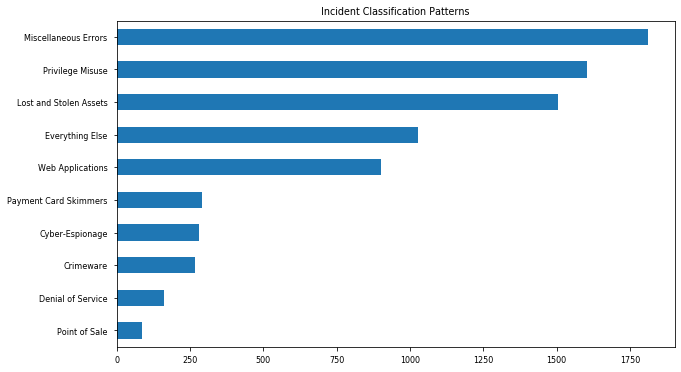

In [94]:
plt.figure(figsize=(10,6))
plt.title('Incident Classification Patterns')
pd.Series(target_encoder.inverse_transform(y)).value_counts(ascending=True).plot(kind='barh')
plt.savefig('figs/patterns.png')

# Comparison of several different models

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.is_copy = None
X_val.is_copy = None
cat_cols = list(X_train.select_dtypes('O').columns)

preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor.transform(X_val)

X_train_preprocessed = ADASYN().fit_resample(X_train_preprocessed, y_train)

[IterativeImputer] Completing matrix with shape (6347, 472)
[IterativeImputer] Ending imputation round 1/10, elapsed time 113.94
[IterativeImputer] Change: 3065287.491113327, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1587, 472)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.17


In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_noaction, y, test_size=0.2, random_state=42)
X_train.is_copy = None
X_val.is_copy = None
cat_cols = list(X_train.select_dtypes('O').columns)

preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor.transform(X_val)

[IterativeImputer] Completing matrix with shape (6347, 204)
[IterativeImputer] Ending imputation round 1/10, elapsed time 11.10
[IterativeImputer] Change: 3065239.899454053, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1587, 204)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.08


In [123]:
import imblearn
from imblearn.combine import SMOTETomek

In [124]:
pd.Series(target_encoder.inverse_transform(y_train)).value_counts()

Miscellaneous Errors      1470
Privilege Misuse          1265
Lost and Stolen Assets    1214
Everything Else            812
Web Applications           720
Payment Card Skimmers      242
Crimeware                  219
Cyber-Espionage            217
Denial of Service          123
Point of Sale               65
dtype: int64

In [127]:
sampler = SMOTETomek()
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

In [128]:
pd.Series(target_encoder.inverse_transform(y_train_resampled)).value_counts()

Denial of Service         1458
Cyber-Espionage           1436
Payment Card Skimmers     1433
Point of Sale             1422
Crimeware                 1414
Web Applications          1363
Everything Else           1319
Privilege Misuse          1295
Lost and Stolen Assets    1295
Miscellaneous Errors      1271
dtype: int64

In [130]:
def compare_models(data, labels, exc_cols=[]):
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train.is_copy = None
    X_val.is_copy = None
    cat_cols = list(data.select_dtypes('O').columns)
    
    print(np.unique(y_train))
    print(np.unique(y_val))
    preprocessor = Pipeline(([
        ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in exc_cols])),
        ('imputer', IterativeImputer(verbose=2))
    ]))
    sampler = SMOTETomek()
    
    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    print(X_train_preprocessed.shape, y_train.shape)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
#     print(pd.Series(y_train_resampled).value_counts())
    models = {
        'XGBoost': {
            'model': XGBClassifier(),
            'c_line' : 'b'
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'c_line': 'g'
        },
        'SVM': {
            'model': SVC(probability=True),
            'c_line': 'm'
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'c_line': 'y'
        }
    }
    
    names = []
    entropy = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    

#     fig = plt.figure(figsize=figsize)

    for model_name, model in models.items():

        t0 = datetime.datetime.now()

        print('Fitting %s...\n'%model_name)

        clf = model['model']
        
        if model_name == 'Naive Bayes':
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(X_train_resampled)
            x_test = scaler.transform(X_val_preprocessed)
        else:
            x_train = X_train_resampled
            x_test = X_val_preprocessed
        y_train = y_train_resampled
        y_test = y_val

        clf.fit(x_train, y_train)

        print('%s Fitted!'%model_name)
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

        print('---------------------------------------------------')
        print('Predicting on validation data...')
        y_pred_proba = clf.predict_proba(x_test)
        y_pred = clf.predict(x_test)

        print('Predictions Completed')
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
        print('---------------------------------------------------')
        
        names.append(model_name)
        
        cross_entropy_loss = log_loss(y_test, y_pred_proba)
        entropy.append(cross_entropy_loss)
#         models[model_name]['roc-auc'] = roc_auc

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
#         models[model_name]['accuracy'] = accuracy

        precision = precision_score(y_test, y_pred, average='micro')
        precisions.append(precision)
#         models[model_name]['precision'] = precision

        recall = recall_score(y_test, y_pred, average='micro')
        recalls.append(recall)
#         models[model_name]['recall'] = recall

        f1 = f1_score(y_test, y_pred, average='micro')
        f1s.append(f1)
#         models[model_name]['f1 score'] = f1

        print('Accuracy Score: {:.2%}'.format(accuracy))
        print('Precision Score: {:.2%}'.format(precision))
        print('Recall Score: {:.2%}'.format(recall))
        print('F1 Score: {:.2%}'.format(f1))
        print('Cross Entropy Loss: {:.4f}'.format(cross_entropy_loss))
        print('---------------------------------------------------')
        print('Classification Report:')
        print(classification_report(y_test, y_pred))
        print('---------------------------------------------------')
        print('\nConfusion Matrix:')
        confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
        print(confusion)
        print('\n\n===================================================')
#         fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
#         # fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, models[model_name]['c_line'], label = '%s (AUC = %0.2f)' % (model_name, roc_auc))
    
    results = pd.DataFrame({
        'Model Name': names,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1s,
        'Cross Entropy Loss': entropy
    })
    # make the plot
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.title(title)
#     plt.savefig('figs/results_figs/%s.png'%title.replace(' ', '_'))
#     plt.show()
    
    return results

### With Action Columns

In [137]:
results = compare_models(X, y)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[IterativeImputer] Completing matrix with shape (6347, 472)
[IterativeImputer] Ending imputation round 1/10, elapsed time 117.53
[IterativeImputer] Change: 3065287.491113327, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1587, 472)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.21
(6347, 472) (6347,)
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:38
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:38
---------------------------------------------------
Accuracy Score: 96.16%
Precision Score: 96.16%
Recall Score: 96.16%
F1 Score: 96.16%
Cross Entropy Loss: 0.1847
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
   

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Predictions Completed
Total Time Elapsed - 0:0:0
---------------------------------------------------
Accuracy Score: 61.75%
Precision Score: 61.75%
Recall Score: 61.75%
F1 Score: 61.75%
Cross Entropy Loss: 12.9231
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        48
           1       0.24      0.90      0.38        63
           2       1.00      0.77      0.87        39
           3       0.94      0.21      0.35       214
           4       0.55      0.96      0.70       291
           5       1.00      0.99      0.99       342
           6       0.71      0.96      0.81        48
           7       0.09      0.74      0.17        23
           8       0.94      0.22      0.35       339
           9       0.97      0.32      0.48       180

    accuracy                           0.62      1587
   macro avg       0.73      0.68      0.59      1587
weighte

In [145]:
results.to_clipboard()
results

,Model Name,Accuracy,Precision,Recall,F1 Score,Cross Entropy Loss
0,XGBoost,0.961563,0.961563,0.961563,0.961563,0.184722
1,Random Forest,0.952111,0.952111,0.952111,0.952111,0.267886
2,SVM,0.036547,0.036547,0.036547,0.036547,2.296291
3,Naive Bayes,0.617517,0.617517,0.617517,0.617517,12.923063


### Without Action Columns

In [133]:
results_noaction = compare_models(X_noaction, y)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[IterativeImputer] Completing matrix with shape (6347, 204)
[IterativeImputer] Ending imputation round 1/10, elapsed time 11.08
[IterativeImputer] Change: 3065239.899454053, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1587, 204)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.07
(6347, 204) (6347,)
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:20
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:20
---------------------------------------------------
Accuracy Score: 60.62%
Precision Score: 60.62%
Recall Score: 60.62%
F1 Score: 60.62%
Cross Entropy Loss: 1.2586
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.31      0.31        48
    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [143]:
results_noaction.to_clipboard()
results_noaction

,Model Name,Accuracy,Precision,Recall,F1 Score,Cross Entropy Loss
0,XGBoost,0.606175,0.606175,0.606175,0.606175,1.258566
1,Random Forest,0.562697,0.562697,0.562697,0.562697,1.685206
2,SVM,0.035917,0.035917,0.035917,0.035917,2.327114
3,Naive Bayes,0.173283,0.173283,0.173283,0.173283,27.825876


---
# Hyperparameter Tuning

In [139]:
import optunity
import optunity.metrics

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y, test_size=0.2, random_state=42)
# Define our Objective Function
@optunity.cross_validated(x=X_train.values, y=y_train, num_folds=3)
# @optunity.cross_validated(x=X_train_resampled, y=y_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
    
    # categorical encoding
#     print('M-encoding categoricals')
    x_train_df = pd.DataFrame(x_train, columns = X_noaction.columns)
    x_test_df = pd.DataFrame(x_test, columns = X_noaction.columns)
    cat_cols = list(x_train_df.select_dtypes('O').columns)
    assert all([col in x_train_df for col in cat_cols])
    
    m_encoder = MEstimateEncoder(cols=cat_cols)
    x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
    x_test_enc = m_encoder.transform(x_test_df)
    
    # imputation
#     print('Imputing nulls')
    imputer = IterativeImputer(verbose=0)
    x_train_imp = imputer.fit_transform(x_train_enc)
    x_test = imputer.transform(x_test_enc)
        
    # oversampling
#     print('Oversampling')
    sampler = SMOTETomek()
    x_train, y_train = sampler.fit_resample(x_train_imp, y_train)
    
#     print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 0
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = f1_score(y_test, y_pred, average='micro')
    print('F1 Score= {:.2%}'.format(score), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return score

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

pat_optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                            num_evals = 100, 
                                            # define hyperparameter grid
                                            n_estimators = [100, 1000], 
                                            max_depth = [2, 10], 
                                            min_child_weight = [1, 7],
                                            gamma = [0.1, 2],
                                            colsample_bytree = [0.3, 1],
                                            subsample = [0.2, 0.7],
                                            reg_alpha = [0, 1],
                                            reg_lambda = [1, 5]
                                           )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

pat_optimum['n_estimators'] = round(pat_optimum['n_estimators'])
pat_optimum['max_depth'] = round(pat_optimum['max_depth'])
pat_optimum

Tuning XGBoost...
----------------------------

F1 Score= 60.43% | Total Time Elapsed - 0:1:21
F1 Score= 60.02% | Total Time Elapsed - 0:2:47
F1 Score= 59.92% | Total Time Elapsed - 0:4:7
F1 Score= 60.00% | Total Time Elapsed - 0:5:27
F1 Score= 59.74% | Total Time Elapsed - 0:6:50
F1 Score= 58.27% | Total Time Elapsed - 0:8:9
F1 Score= 57.87% | Total Time Elapsed - 0:9:17
F1 Score= 59.78% | Total Time Elapsed - 0:10:28
F1 Score= 58.36% | Total Time Elapsed - 0:11:32
F1 Score= 60.28% | Total Time Elapsed - 0:12:14
F1 Score= 60.07% | Total Time Elapsed - 0:13:0
F1 Score= 59.07% | Total Time Elapsed - 0:13:41
F1 Score= 59.95% | Total Time Elapsed - 0:15:51
F1 Score= 60.87% | Total Time Elapsed - 0:18:10
F1 Score= 59.07% | Total Time Elapsed - 0:20:15
F1 Score= 58.16% | Total Time Elapsed - 0:21:28
F1 Score= 58.70% | Total Time Elapsed - 0:22:44
F1 Score= 57.84% | Total Time Elapsed - 0:23:55
F1 Score= 60.47% | Total Time Elapsed - 0:24:32
F1 Score= 61.11% | Total Time Elapsed - 0:25:10
F1

NameError: name 'pat_optimum' is not defined

In [149]:
pat_optimum = ava_optimum

In [152]:
pat_optimum['n_estimators'] = round(pat_optimum['n_estimators'])
pat_optimum['max_depth'] = round(pat_optimum['max_depth'])
pat_optimum

{'n_estimators': 186,
 'max_depth': 10,
 'min_child_weight': 2.130170973824754,
 'gamma': 1.4566917418170162,
 'colsample_bytree': 0.3005895779658183,
 'subsample': 0.6849039562013987,
 'reg_alpha': 0.8273795114702875,
 'reg_lambda': 3.743423676064291}

---
# Evaluating Model Tuning

In [205]:
X_train, X_val, y_train, y_val = train_test_split(X_noaction, y, test_size=0.2, random_state=42)
X_train.is_copy = None
X_val.is_copy = None
cat_cols = list(X_noaction.select_dtypes('O').columns)

print(np.unique(y_train))
print(np.unique(y_val))
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=cat_cols)),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = SMOTETomek()

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor.transform(X_val)
print(X_train_preprocessed.shape, y_train.shape)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
#     print(pd.Series(y_train_resampled).value_counts())

names = []
entropy = []
accuracies = []
precisions = []
recalls = []
f1s = []

#     fig = plt.figure(figsize=figsize)

t0 = datetime.datetime.now()

xgb = XGBClassifier(**pat_optimum)
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('---------------------------------------------------')
print('Predicting on validation data...')
y_pred_proba = xgb.predict_proba(X_val_preprocessed)
y_pred = xgb.predict(X_val_preprocessed)

print('Predictions Completed')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('---------------------------------------------------')

cross_entropy_loss = log_loss(y_val, y_pred_proba)
entropy.append(cross_entropy_loss)
#         models[model_name]['roc-auc'] = roc_auc

accuracy = accuracy_score(y_val, y_pred)
accuracies.append(accuracy)
#         models[model_name]['accuracy'] = accuracy

precision = precision_score(y_val, y_pred, average='micro')
precisions.append(precision)
#         models[model_name]['precision'] = precision

recall = recall_score(y_val, y_pred, average='micro')
recalls.append(recall)
#         models[model_name]['recall'] = recall

f1 = f1_score(y_val, y_pred, average='micro')
f1s.append(f1)
#         models[model_name]['f1 score'] = f1

print('Accuracy Score: {:.2%}'.format(accuracy))
print('Precision Score: {:.2%}'.format(precision))
print('Recall Score: {:.2%}'.format(recall))
print('F1 Score: {:.2%}'.format(f1))
print('Cross Entropy Loss: {:.4f}'.format(cross_entropy_loss))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_val, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_val, y_pred))
print(confusion)
print('\n\n===================================================')
#         fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
#         # fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, models[model_name]['c_line'], label = '%s (AUC = %0.2f)' % (model_name, roc_auc))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[IterativeImputer] Completing matrix with shape (6347, 204)
[IterativeImputer] Ending imputation round 1/10, elapsed time 11.84
[IterativeImputer] Change: 3065239.899454053, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1587, 204)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.08
(6347, 204) (6347,)
XGBoost Fitted!
Total Time Elapsed - 0:0:26
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:26
---------------------------------------------------
Accuracy Score: 59.17%
Precision Score: 59.17%
Recall Score: 59.17%
F1 Score: 59.17%
Cross Entropy Loss: 1.1320
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.35      0.35        48
           1       0.76 

# Interpretability

In [166]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = SMOTETomek()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y)

print('Resampling data...')
X_resampled, y_resampled = sampler.fit_resample(X_preprocessed, y)

print('Fiting XGBoost...')
xgb = XGBClassifier(**pat_optimum)
xgb.fit(X_resampled, y_resampled)

print('SHAP explanations...')
shap_explainer = shap.TreeExplainer(xgb)
shap_values = shap_explainer.shap_values(X_resampled)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7934, 207)
[IterativeImputer] Ending imputation round 1/10, elapsed time 17.26
[IterativeImputer] Change: 7092959.6282303585, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...
Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [174]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

In [185]:
list(target_encoder.inverse_transform(range(10)))

['Crimeware',
 'Cyber-Espionage',
 'Denial of Service',
 'Everything Else',
 'Lost and Stolen Assets',
 'Miscellaneous Errors',
 'Payment Card Skimmers',
 'Point of Sale',
 'Privilege Misuse',
 'Web Applications']

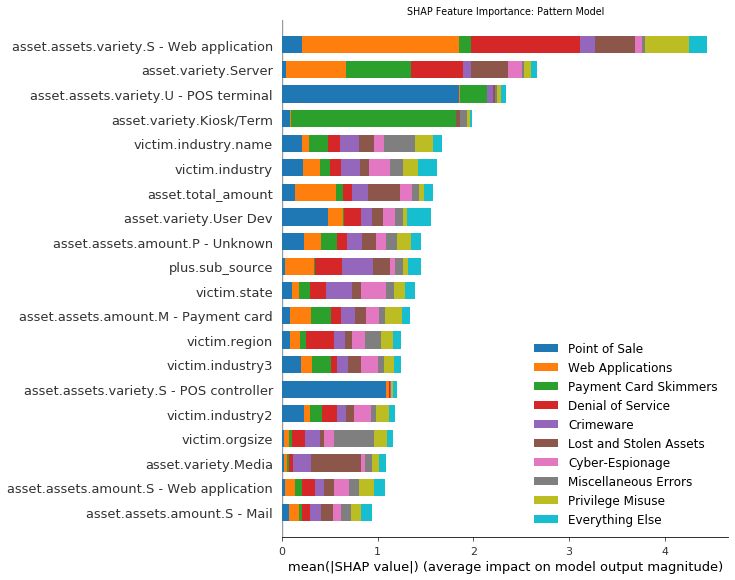

In [219]:
plt.title('SHAP Feature Importance: Pattern Model')
shap.summary_plot(shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns), 
                  class_names=target_encoder.inverse_transform(range(10)), color=plt.get_cmap("tab10"), show=False)
f = plt.gcf()
plt.savefig('figs/results_figs/pattern/tuned_xgb_SHAP.png', bbox_inches='tight')

In [206]:
sample = pd.DataFrame(X_resampled, columns=X_noaction.columns).sample(1).iloc[0]
sample_idx = sample.name
shap.force_plot(shap_explainer.expected_value, shap_values[sample_idx], pd.DataFrame(X_resampled, columns=X_noaction.columns).iloc[sample_idx,:], link="logit")

IndexError: list index out of range

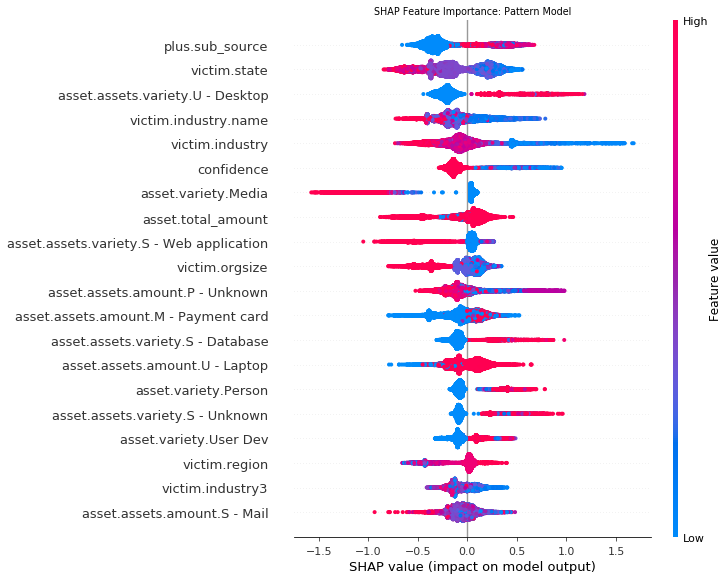

In [196]:
plt.title('SHAP Feature Importance: Pattern Model')
shap.summary_plot(shap_values[0], pd.DataFrame(X_resampled, columns=X_noaction.columns), 
                  class_names=target_encoder.inverse_transform(range(10)), show=False)
f0 = plt.gcf()
# plt.savefig('figs/results_figs/pattern/shap/tuned_xgb_SHAP.png')
plt.show()

In [201]:
target_encoder.inverse_transform([0])[0]

'Crimeware'

In [215]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

In [210]:
import tqdm

In [216]:
for i in tqdm.tqdm(range(10)):
    class_name = target_encoder.inverse_transform([i])[0]
    plt.title('SHAP Feature: Pattern Model - %s Predictions'%class_name)
    shap.summary_plot(shap_values[i], pd.DataFrame(X_resampled, columns=X_noaction.columns), 
                      class_names=target_encoder.inverse_transform(range(10)), show=False)
    plt.savefig('figs/results_figs/pattern/shap/pattern_shap_%s.png'%class_name.replace(' ','_'), bbox_inches='tight')
    fig=plt.gcf()
    plt.close(fig)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.30s/it]


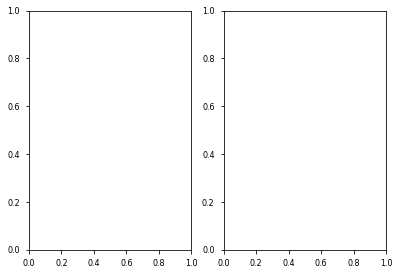

In [198]:
fig, ax = plt.subplots(1, 2)

---
# K-fold ting

In [159]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)

In [160]:
np.mean([1,2,3,4])

2.5

In [161]:
accuracy = []
precision = []
recall = []
f1 = []
cross_entropy_loss = []

for train_idx, val_idx in rs.split(X):
    X_train = X.iloc[train_idx]
    y_train = y[train_idx]
    
    X_val = X.iloc[val_idx]
    y_val = y[val_idx]
    
    X_train.is_copy = None
    X_val.is_copy = None
    cat_cols = list(X.select_dtypes('O').columns)

    preprocessor = Pipeline(([
        ('encoder', MEstimateEncoder(cols=cat_cols)),
        ('imputer', IterativeImputer(verbose=2))
    ]))
    sampler = ADASYN()

    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

    clf = XGBClassifier()
    clf.fit(X_train_resampled, y_train_resampled)

    y_pred = clf.predict(X_val_preprocessed)
    y_pred_proba = clf.predict_proba(X_val_preprocessed)
    y_test = y_val

    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))
    cross_entropy_loss.append(log_loss(y_test, y_pred_proba))

# print('ROC-AUC Score: {:.2%}'.format(roc_auc))
print('Accuracy Score: {:.2%}'.format(np.mean(accuracy)))
print('Precision Score: {:.2%}'.format(np.mean(precision)))
print('Recall Score: {:.2%}'.format(np.mean(recall)))
print('F1 Score: {:.2%}'.format(np.mean(f1)))
print('Cross Entropy Loss: {:.4f}'.format(np.mean(cross_entropy_loss)))
# print('---------------------------------------------------')
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

[IterativeImputer] Completing matrix with shape (5950, 470)
[IterativeImputer] Ending imputation round 1/10, elapsed time 161.10
[IterativeImputer] Change: 1200593.0593082942, scaled tolerance: 469160000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1984, 470)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.38
[IterativeImputer] Completing matrix with shape (5950, 472)
[IterativeImputer] Ending imputation round 1/10, elapsed time 161.11
[IterativeImputer] Change: 560302.9227969714, scaled tolerance: 469160000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1984, 472)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.45
[IterativeImputer] Completing matrix with shape (5950, 473)
[IterativeImputer] Ending imputation round 1/10, elapsed time 154.77
[IterativeImputer] Change: 6784801.810974851, scaled tolerance: 6800000000.0 
[IterativeImputer] Ear

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Incident Classification Patterns')
pd.Series(target_encoder.inverse_transform(y_train_resampled)).value_counts(ascending=True).plot(kind='barh')plt.savefig('figs/patterns.png')